In [7]:
import requests
import re
import numpy as np
import matplotlib.pyplot as plt

# COnfig
## Define Protein Sequences to run here:
protein_sequences = [ "Q15836", "Q01524", "P02652", "P02818", "O60516", "P05114", "Q9BXV9", "Q9BV40", "P00974", "P0AFE4"]

In [8]:
# Using Uniprot API to get protein sequence

# Query to fetch 10 random sequences of length 100
"https://rest.uniprot.org/uniprotkb/search?query=(length:[100 TO {100}])&format=fasta&size=10"

def getProtSeq(accession):
    url = f"https://www.uniprot.org/uniprot/{accession}.fasta"
    response = requests.get(url)
    return response.text



In [9]:
def format_fasta(seq):
    data = {"header": {}, "sequence": ""}
    header = r'^>(sp|tr)\|([A-Z0-9]+)\|([A-Z0-9_]+)\s+(.+?)\s+OS=(.+?)\s+OX=(\d+)(?:\s+GN=([^\s]+))?(?:\s+PE=(\d+))?(?:\s+SV=(\d+))?' # Makes GN an optional field cause for some reason some data didnt have it
    filtered_seq = re.match(header, seq)

    if seq == "":
        return print("EMPTY DATA FETCHED. Check the accession again.")
    
    
    if filtered_seq:
        data["header"]["accession"] = filtered_seq.group(2)
        data["header"]["name"] = filtered_seq.group(3)
        data["header"]["description"] = filtered_seq.group(4)
        data["header"]["organism"] = filtered_seq.group(5)
        data["header"]["ox"] = filtered_seq.group(6)
        data["header"]["gene"] = filtered_seq.group(7)
        data["header"]["pe"] = filtered_seq.group(8)
        data["header"]["sv"] = filtered_seq.group(9)
    
        data["sequence"] = seq.splitlines()[1:]
    return data

# format_fasta(getProtSeq("P69905"))


In [10]:
class protein:
    def __init__(self, accession):
        self.accession = accession
        self.sequence = None
        self.header = None

    def fetch_sequence(self):
        fasta_data = getProtSeq(self.accession)
        formatted_data = format_fasta(fasta_data)
        self.sequence = formatted_data["sequence"]
        self.header = formatted_data["header"]

    def format_sequence(self):
        seq = ''.join(self.sequence)
        seq = seq.replace("\n", "")
        return seq


    def __str__(self):
        return f"Protein {self.accession} - {self.header['description']}"
    
    def getNmer(self,n):
        nmer = []
        seq = self.format_sequence()
        for i in range(len(seq) - n + 1):
            nmer.append(seq[i:i+n])
        return nmer
    
    def findMotif(self):
        seq = self.format_sequence()

        motif = input("Enter the regex motif to search for: ")

        matches = re.finditer(motif, seq) # multiple times
        for match in matches:
            start = match.start()
            end = match.end()
            print(f"Match found at position {start} to {end}: {match.group()}")

        return 


In [11]:
protein_objects = [] # This are class objects
for accession in protein_sequences:
    prot = protein(accession)
    prot.fetch_sequence()
    protein_objects.append(prot)

In [12]:

#Example Uasage
print(protein_objects[0].header)
print(protein_objects[0].sequence)


{'accession': 'Q15836', 'name': 'VAMP3_HUMAN', 'description': 'Vesicle-associated membrane protein 3', 'organism': 'Homo sapiens', 'ox': '9606', 'gene': 'VAMP3', 'pe': '1', 'sv': '3'}
['MSTGPTAATGSNRRLQQTQNQVDEVVDIMRVNVDKVLERDQKLSELDDRADALQAGASQF', 'ETSAAKLKRKYWWKNCKMWAIGITVLVIFIIIIIVWVVSS']


### Get nMer of the Sequence (Define it below)

In [ ]:
# Example usage of finding MOTIF:
prot_seq = protein_objects[0]
prot_seq.findMotif() # Input: P.{3}


### Getting Shannon Entropy

In [ ]:
# REFERENCE: http://imed.med.ucm.es/Tools/svs_help.html
"""
= 0.0 : Fully conserved (only 1 amino acid appears)
< 1.0 : Highly conserved position
< 2.0 : Conserved
> 2.0 : Variable position
--Max : All amino acids equally likely
"""

# sequence_list = np.array([p.format_sequence().strip() for p in protein_objects])


nmer_dict = {}

for i, prot in enumerate(protein_objects):
    nmer_dict[i] = {}
    for n in range(3, 10):
        nmers = prot.getNmer(n)
        nmer_dict[i][n] = nmers

nmer_dict


def compute_entropy(sequence):
    length = len(sequence)
    freq = {}

    for char in sequence:
        freq[char] = freq.get(char, 0) + 1

    probs = [count / length for count in freq.values()]
    entropy = -sum(p * np.log2(p) for p in probs if p > 0)
    return entropy

entropy_dict = {}

for prot_index, nmer_lengths in nmer_dict.items():
    entropy_dict[prot_index] = {}
    
    for n, nmer_list in nmer_lengths.items():
        entropy_dict[prot_index][n] = []
        
        for nmer in nmer_list:
            entropy = compute_entropy(nmer)
            entropy_dict[prot_index][n].append(entropy)

entropy_dict

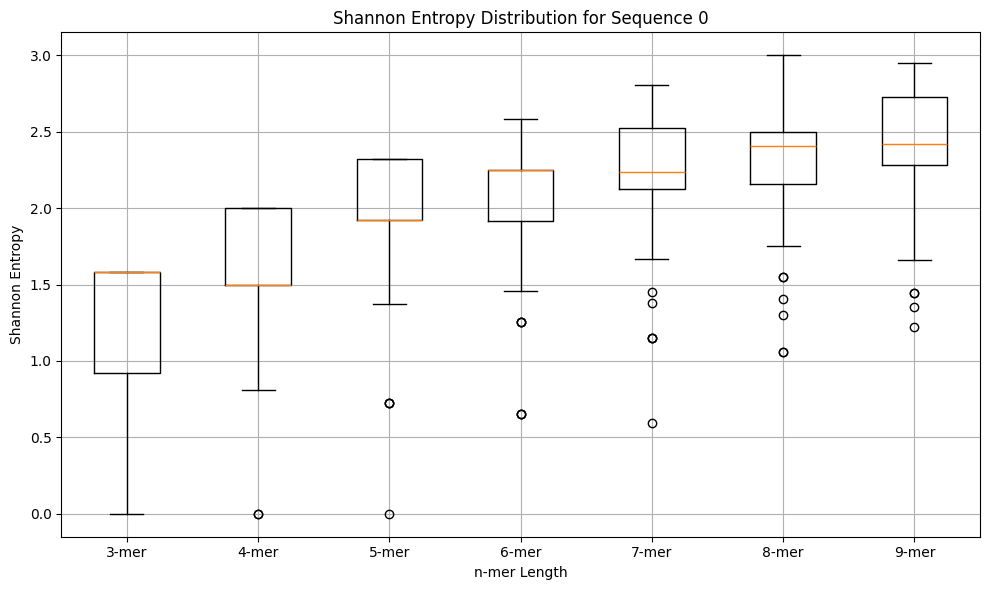

In [15]:
# FUnction to plot along one sequence for all n-mers (3-9)

def plot_entropy_box(sequence_index, entropy_dict):
    if sequence_index not in entropy_dict:
        print(f"Sequence index {sequence_index} not found.")
        return

    data = []
    labels = []

    for n in range(3, 10):
        entropies = entropy_dict[sequence_index].get(n, [])
        if entropies:
            data.append(entropies)
            labels.append(f"{n}-mer")

    if not data:
        print("No entropy data to plot.")
        return

    plt.figure(figsize=(10, 6))
    plt.boxplot(data, labels=labels)
    plt.title(f"Shannon Entropy Distribution for Sequence {sequence_index}")
    plt.xlabel("n-mer Length")
    plt.ylabel("Shannon Entropy")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


plot_entropy_box(0,entropy_dict)

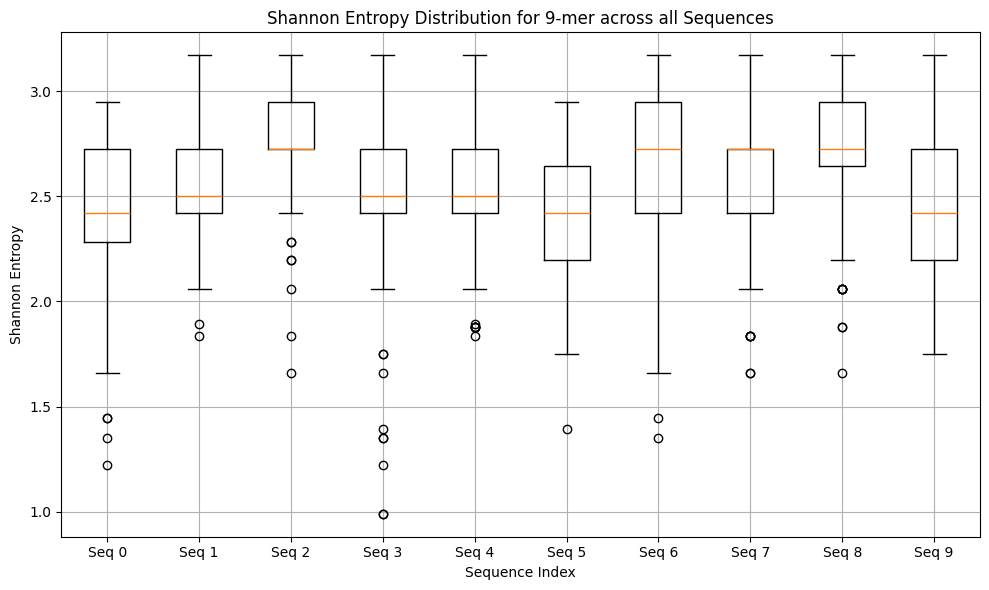

In [16]:
def plot_entropy_for_nmer(n, entropy_dict):
    data = []
    labels = []

    for sequence_index, nmer_lengths in entropy_dict.items():
        entropies = nmer_lengths.get(n, [])
        if entropies:
            data.append(entropies)
            labels.append(f"Seq {sequence_index}")

    if not data:
        print(f"No entropy data available for {n}-mer.")
        return

    plt.figure(figsize=(10, 6))
    plt.boxplot(data, labels=labels)
    plt.title(f"Shannon Entropy Distribution for {n}-mer across all Sequences")
    plt.xlabel("Sequence Index")
    plt.ylabel("Shannon Entropy")
    # plt.xticks(rotation=90)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_entropy_for_nmer(9,entropy_dict)